In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from google.colab import files
import io

uploaded = files.upload()
train = pd.read_csv(io.BytesIO(uploaded['NFLPlaysDataset.csv']), sep=',')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Saving NFLPlaysDataset.csv to NFLPlaysDataset.csv


In [0]:
train.head()

,Result,Down,FirstDownDistance,PointDifference,EndZoneDistance,Quarter,Minutes,Seconds,Opponent
0,Run,1,10,0,75,1,15,0,Bears
1,Pass,2,10,0,75,1,14,33,Bears
2,Pass,3,10,0,75,1,13,45,Bears
3,Punt,4,20,0,85,1,13,15,Bears
4,Pass,1,10,0,88,1,9,39,Bears


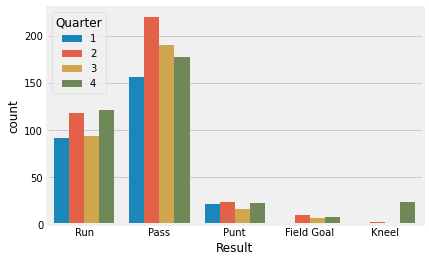

In [0]:
sns.countplot('Result', hue='Quarter', data=train)
plt.show()

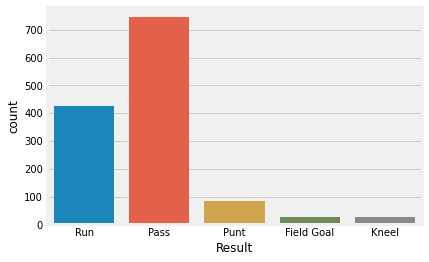

In [0]:
sns.countplot('Result', data=train)
plt.show()

One of the issues I was having when I first started training the model was that it was only about 65% accurate most of the time. As you can see from this graph, the issue came from the fact that other play results didn't have nearly as much data as Run and Pass. I decided to copy the data for each of the classes that didn't have as much and append it to the list so that each play result had roughly the same amount of data. This alone increased the validation accuracy by roughly 20%.

In [0]:
run_count = 0
pass_count = 0
punt_count = 0
fieldgoal_count = 0
kneel_count = 0
for index, row in train.iterrows():
  if row['Result'] == 'Run':
    run_count += 1
  elif row['Result'] == 'Pass':
    pass_count += 1
  elif row['Result'] == 'Punt':
    punt_count += 1
  elif row['Result'] == 'Field Goal':
    fieldgoal_count += 1
  elif row['Result'] == 'Kneel':
    kneel_count += 1

print(f"Total runs: {run_count}")
print(f"Total passes: {pass_count}")
print(f"Total punts: {punt_count}")
print(f"Total field goals: {fieldgoal_count}")
print(f"Total kneels: {kneel_count}")

Total runs: 425
Total passes: 745
Total punts: 85
Total field goals: 26
Total kneels: 26


In [0]:
# 320 more runs
# 660 more punts - 7 more times
# 719 more field goals - 27 more times
# 719 more kneels - 27 more times
runs = []
punts = []
fieldgoals = []
kneels = []
for index, row in train.iterrows():
  if row['Result'] == 'Run':
    runs.append(row)
  if row['Result'] == 'Punt':
    punts.append(row)
  elif row['Result'] == 'Field Goal':
    fieldgoals.append(row)
  elif row['Result'] == 'Kneel':
    kneels.append(row)

train = train.append(runs)
for _ in range(7):
  train = train.append(punts)
for _ in range(27):
  train = train.append(fieldgoals)
  train = train.append(kneels)

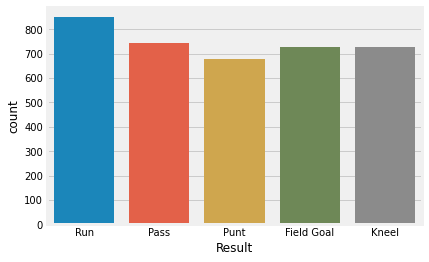

In [0]:
sns.countplot('Result', data=train)
plt.show()

I decided to use numeric values for the play result and opponents so that I kept the same number of rows instead of adding rows from using one-hot encoding.

In [0]:
#  rewrite labels to numeric values
#  0 run, 1 pass, 2 punt, 3 field goal, 4 kneel
play_result = ['Run', 'Pass', 'Punt', 'Field Goal', 'Kneel']
opponents = ['Cardinals', 'Falcons', 'Ravens', 'Bills', 'Panthers', 'Bears', 'Bengals', 'Browns',
             'Cowboys', 'Broncos', 'Lions', 'Texans', 'Colts', 'Jaguars', 'Chiefs', 'Raiders', 
             'Chargers', 'Rams', 'Dolphins', 'Vikings', 'Patriots', 'Saints', 'Giants', 'Jets',
             'Eagles', 'Steelers', '49ers', 'Seahawks', 'Buccaneers', 'Titans', 'Redskins']
play_result_replace = [0, 1, 2, 3, 4]
opponents_replace = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]

# replace text values with numeric values
train['Result'] = train['Result'].replace(play_result, play_result_replace)
train['Opponent'] = train['Opponent'].replace(opponents, opponents_replace)

When gathering my data, I decided to put the play result, which is my output, in the first column. I did this so that it would be easier to access when splitting my data in X_train and y_train.

In [0]:
train.head()

,Result,Down,FirstDownDistance,PointDifference,EndZoneDistance,Quarter,Minutes,Seconds,Opponent
0,0,1,10,0,75,1,15,0,5
1,1,2,10,0,75,1,14,33,5
2,1,3,10,0,75,1,13,45,5
3,2,4,20,0,85,1,13,15,5
4,1,1,10,0,88,1,9,39,5


In [0]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler(copy=True)
train_std = scaler.fit_transform(X=train.iloc[:,1:], y=train.iloc[:,0])
train_std

array([[-1.32202738,  0.27810397, -0.24595336, ...,  2.05812035,
        -1.55528199, -1.29958599],
       [-0.50741398,  0.27810397, -0.24595336, ...,  1.84847045,
         0.39478761, -1.29958599],
       [ 0.30719943,  0.27810397, -0.24595336, ...,  1.63882054,
         1.10390382, -1.29958599],
       ...,
       [-1.32202738,  0.27810397,  0.25941726, ..., -0.8769783 ,
         1.28118288,  1.42540806],
       [-0.50741398,  0.27810397,  0.25941726, ..., -0.8769783 ,
        -0.72797973,  1.42540806],
       [ 0.30719943,  0.48641674,  0.25941726, ..., -1.08662821,
         0.6902527 ,  1.42540806]])

In [0]:
train_std.shape

(3731, 8)

In [0]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(train_std, train.iloc[:,0], test_size=0.2)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [0]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2984, 8)
(2984, 5)
(747, 8)
(747, 5)


Start creating the Neural Net

In [0]:
%tensorflow_version 2.x

In [0]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [EarlyStopping(monitor='val_loss', patience=4),
             ModelCheckpoint(filepath='play_predictor.h5', monitor='val_loss', save_best_only=True)]

For my model, I used the softmax activation function for my output layer since my problem is a categorical classification problem. This activation function will give me a value between 0 and 1 and all of the values for the possible play types will add up to 1. I'm using categorical crossentropy as my loss function for the same reason as why I used the softmax activation function.

In [0]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

model = models.Sequential()
model.add(layers.Dense(16, activation='tanh', input_shape=(8,)))
model.add(layers.Dense(16, activation='tanh'))
model.add(layers.Dense(16, activation='elu'))
model.add(layers.Dense(16, activation='elu'))
model.add(layers.Dense(5, activation='softmax'))

optimizer = optimizers.Adam(lr=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
# train the model
history = model.fit(x=X_train, y=y_train, epochs=500, batch_size=256, validation_data=(X_test, y_test), verbose=1)

Epoch 1/500
12/12 [==============================] - 0s 5ms/step - loss: 0.2797 - accuracy: 0.8579 - val_loss: 0.2986 - val_accuracy: 0.8461
Epoch 2/500
12/12 [==============================] - 0s 4ms/step - loss: 0.2776 - accuracy: 0.8603 - val_loss: 0.2987 - val_accuracy: 0.8461
Epoch 3/500
12/12 [==============================] - 0s 5ms/step - loss: 0.2775 - accuracy: 0.8592 - val_loss: 0.2984 - val_accuracy: 0.8501
Epoch 4/500
12/12 [==============================] - 0s 4ms/step - loss: 0.2774 - accuracy: 0.8613 - val_loss: 0.2980 - val_accuracy: 0.8447
Epoch 5/500
12/12 [==============================] - 0s 4ms/step - loss: 0.2762 - accuracy: 0.8653 - val_loss: 0.2973 - val_accuracy: 0.8461
Epoch 6/500
12/12 [==============================] - 0s 4ms/step - loss: 0.2780 - accuracy: 0.8596 - val_loss: 0.2970 - val_accuracy: 0.8447
Epoch 7/500
12/12 [==============================] - 0s 5ms/step - loss: 0.2759 - accuracy: 0.8636 - val_loss: 0.2971 - val_accuracy: 0.8447
Epoch 8/500
1

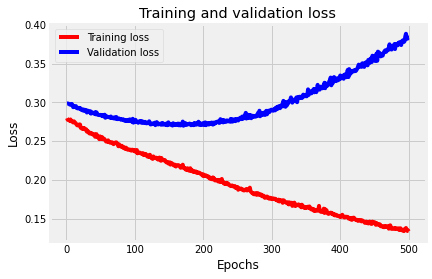

In [0]:
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'r', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

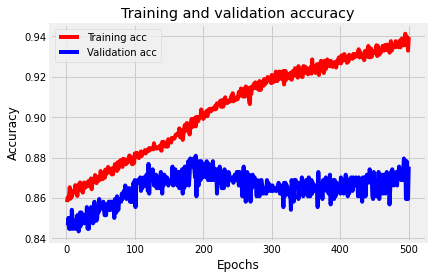

In [0]:
plt.clf()
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

These are just some functions that I will use if I want to use this model with some sort of web platform that people can use to enter in the desired inputs and let it predict what the play will be while also displaying the percentages with each play result option.

In [0]:
def cleanup_output(output):
  for num in output[0]:
    num = round(num * 100, 4)
    print(f"{num}%")

def find_max(output):
  maxNum = -1
  index = -1
  for num in range(len(output[0])):
    if output[0][num] > maxNum:
      maxNum = output[0][num]
      index = num
  return index

In [0]:
predictions = model.predict(X_test[3:4,:])
# convert prediction values to percentages
cleanup_output(predictions)
#print(predictions)
#print(y_test[:4])

play = play_result[find_max(predictions)]
actual_play = play_result[find_max(y_test[3:4])]
print(f"Predicted play: {play}")
print(f"Actual play: {actual_play}")

92.1574%
7.8427%
0.0%
0.0%
0.0%
Predicted play: Run
Actual play: Run


In [0]:
down = 1
firstDownDistance = 10
pointDifference = -3
endzoneDistance = 75
quarter = 2
minutes = 0
seconds = 50
team = 5

prediction = model.predict([[down, firstDownDistance, pointDifference, endzoneDistance,
                             quarter, minutes, seconds, team]])
cleanup_output(prediction)

99.9859%
0.0141%
0.0%
0.0%
0.0%
